# Парсинг сайтов и анализ текстовой информации
Данные: раздел бытовой химии на сайте `irecommend.ru/catalog/list/3769`

### Загрузка пакетов

In [ ]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
import pymorphy2
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Credu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка и проверка данных

In [3]:
# Список для хранения информации о товарах и количестве отзывов
products_info = []

# Проходим по каждой странице в категории "Бытовая Химия"
for page_num in range(0, 30):
    url = f'https://irecommend.ru/catalog/list/3769?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')
    
    for product in products:
        title = product.find('div', class_='title').text
        counter = product.find('span', class_='counter').text
        products_info.append((title, counter))
        
    sleep(randint(8, 11))




In [4]:
df = pd.DataFrame(products_info, columns=['title', 'counter'])

In [5]:
df.head()

,title,counter
0,Ароматизатор воздуха Grass Liberty,1
1,Гель для стирки Septivit+ Всех видов ткани Го...,6
2,Стиральный порошок концентрат Faberlic Премиум...,68
3,КРЕМ для обуви SHOExpert,1
4,Средство для мытья посуды Fairy Pure & Clean,373


### Первичный анализ данных

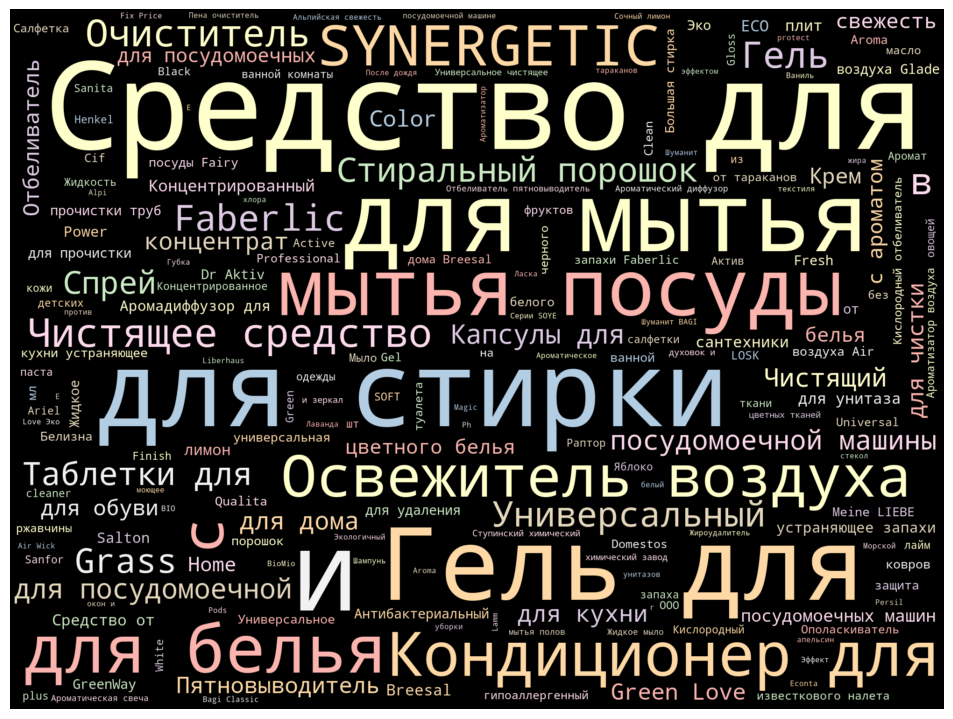

In [6]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется предлог "для"  в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов, а также привести к нормальной форме.

### Обработка данных

In [13]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("russian")

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\b\d+\b', '', title)
    title = re.sub(r'\b\w{1,2}\b', '', title)
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

In [14]:
df['title'] = df['title'].apply(clean_title_lemmatize)

In [15]:
df.head()

,title,counter
0,ароматизатор воздух grass liberty,1
1,гель стирка septivit вид ткань голубой лен,6
2,стиральный порошок концентрат faberlic премиум...,68
3,крем обувь shoexpert,1
4,средство мытьё посуда fairy pure clean,373


### Анализ после обработки

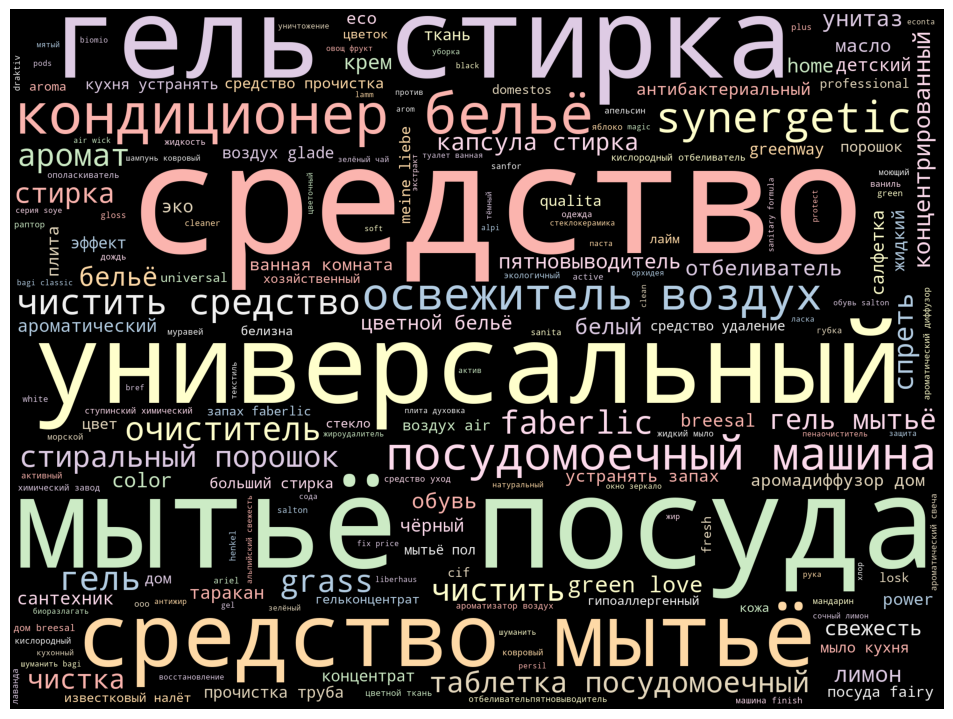

In [16]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Нам удалось обработать текст и выделить наиболее часто встречающиеся темы, которые относятся к бытовой химии. Среди них можно выделить химию, связанную с посудой, а также химию, связанную со стиркой.

### Частотный анализ слов

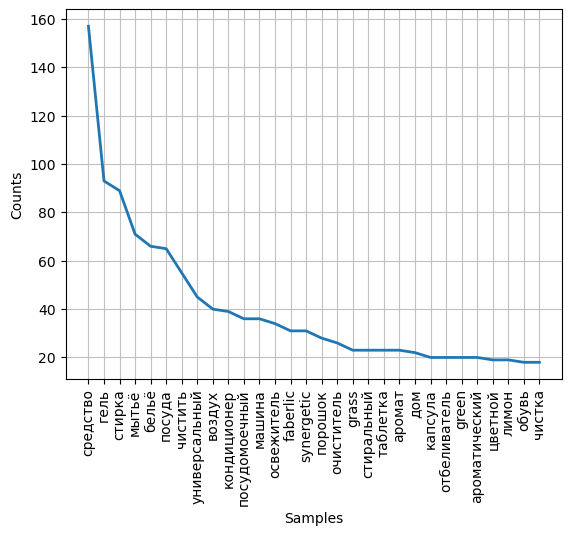

In [17]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Скорее всего, разделение может быть произведено по:

* Средства для стирки
* Средства для мытья посуды
* Очистители
* Освежители воздуха
* Средства для ухода за бельем
* Кондиционеры для белья
* Бренды
* Стиральные машины
* Также все пункты могут быть объединены в одну категорию "Бытовая химия".

### Разделение с помощью TfidVectorizer и CountVectorizer

In [18]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
15                 таблетка посудомоечный машина snowter
16     ополаскиватель посудомоечный машина finish бле...
99     таблетка посудомоечный машина finish powerball...
145           таблетка посудомоечный машина frau schmidt
149    таблетка посудомоечный машина cleanfresh low p...
158    средство мытьё посуда посудомоечный машина gre...
166    таблетка посудомоечный машина alapuresa ecо пр...
176     соль посудомоечный машина molecola таблетировать
190    таблетка посудомоечный машина synergetic эко u...
221         средство посудомоечный машина draktiv teller
245    таблетка посудомоечный машина synergetic биора...
251    таблетка посудомоечный машина reflect dishwash...
269    таблетка мытьё посуда посудомоечный машина fin...
272    капсула мытьё посуда посудомоечный машина fair...
277         таблетка посудомоечный машина somat all один
318          таблетка посудомоечный машина perfect house
320    средство мытьё посуда посудомоечный машина fro...
342                 

In [19]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
70     освежитель воздух synergetic аромат миндаль яб...
93       освежитель воздух synergetic ирис розовый перец
242    аромадиффузор дом breesal arom изысканный насл...
453    освежитель воздух synergetic ягода можжевельни...
Name: title, dtype: object

Cluster 2:
5        средство прочистка труба sanfor антизасор кухня
11     средство прочистка труба expel гель устранение...
13                 средство чистка ванная комната unicum
20      средство чистка духовка плита faberlic серия дом
24     средство окно зеркало synergetic антибактериал...
                             ...                        
592    средство уничтожение таракан муравей блоха про...
593                  универсальный средство econel кухня
595    средство мытьё пол help морской бриз концентри...
597    средство инсектицидный чистый дом гель садовый...
598    средство очистка теплообменный поверхность the...
Name: title, Length: 78, dtype: object

Cluster 3:
131             аромадиффузор дом ama aroma 

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте. Примерные его группы разбиения:

1) Средства для посудомоечных машин

2) Кондиционеры для белья

3) Средства для чистки ванных комнат и туалетов

4) Средства для стирки разных видов тканей

5) Домашний уход

6) Средства для мытья посуды

7) Товары для уборки кухни

8) Средства для очистки сантехники 

9) Кухонные мыла и средства для устранения запахов

10) Освежители воздуха с различными ароматами и названиями брендов

### Визуализация разбиения

In [20]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

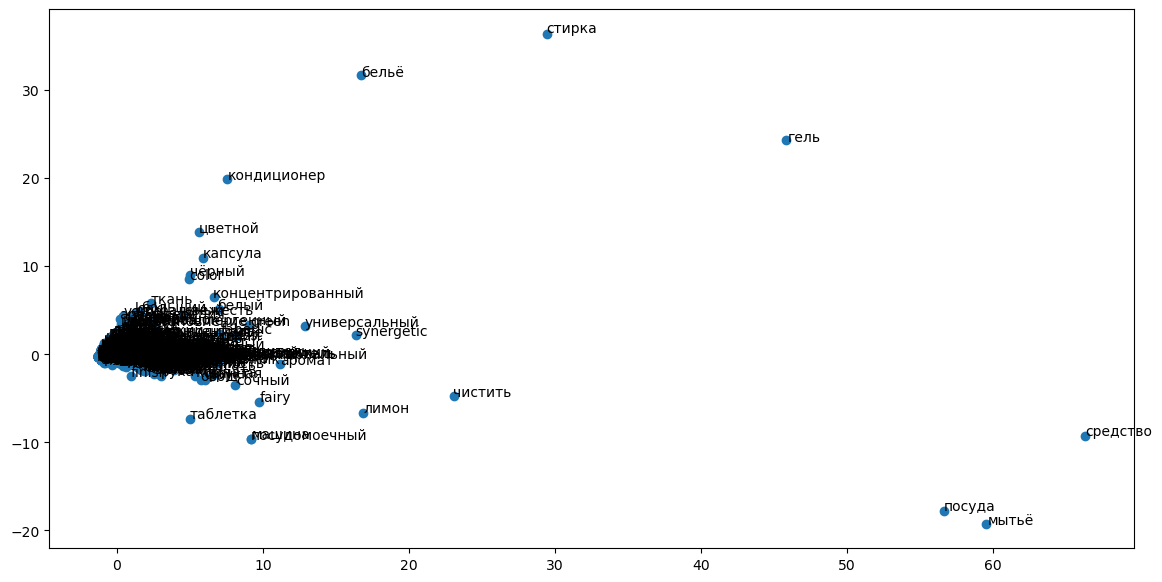

In [21]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

D:\anaconda3\envs\env02\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\envs\env02\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


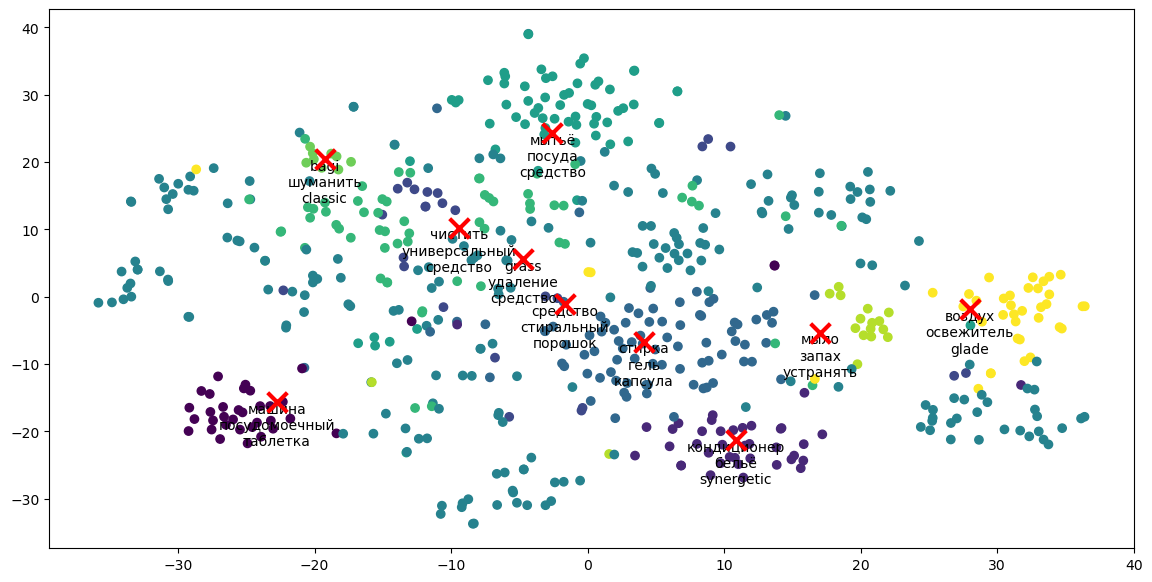

In [22]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [23]:
df['counter'] = df['counter'].astype(int)

df['cluster'] = tfidf_clusters

In [24]:
title_count = df.groupby('cluster')['title'].count()

sum_counts = df.groupby('cluster')['counter'].sum()

stats_df = pd.concat([title_count, sum_counts], axis=1)
stats_df.columns = ['title_count', 'sum_counts']

stats_df

,title_count,sum_counts
cluster,,
0,35,667
1,39,525
2,25,336
3,83,1126
4,225,4070
5,65,3188
6,64,2155
7,9,154
8,17,401


Исходя из таблицы с количеством титлов и суммой отзывов, можно сделать вывод, что товары из 4-го кластера, связанные со средствами для стирки разных видов тканей, наиболее популярны и пользуются наибольшей популярностью среди пользователей. Кластеры 3 (средства для чистки ванных комнат и туалетов), 5 (домашний уход) и 6 (средства для мытья посуды) также имеют довольно большое количество отзывов, что свидетельствует о высоком спросе на товары данных категорий. Кластеры 0 (средства для посудомоечных машин) и 1 (кондиционеры для белья) имеют меньшее количество отзывов, что может говорить о более узкой аудитории потребителей. Остальные кластеры имеют еще меньшее количество отзывов, что может говорить о том, что данные товары пользуются меньшей популярностью или имеют более узкую целевую аудиторию.